<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/tasca1/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from skimage import io
import kagglehub
import pandas as pd
from glob import glob
import cv2
import random
import numpy
from torchvision import transforms
import torch
from torch.utils.data import Dataset

# !rm -rf /content/sample_data/*

# !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

# !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [ ]:
dataset1 = pd.read_csv('/content/sample_data/hmnist_28_28_L.csv')
dataset2 = pd.read_csv('/content/sample_data/hmnist_8_8_L.csv')

In [ ]:
dataset1 = dataset1.drop(columns = dataset1.columns[784])
dataset2 = dataset2.drop(columns = dataset2.columns[64])
print(f"number of (columns,rows) {dataset1.shape}")
print(len(dataset1.iloc[0,:]))
print(dataset1.iloc[784,:].describe())

number of (columns,rows) (10015, 784)
784
count    784.000000
mean     136.783163
std       19.264348
min       30.000000
25%      130.000000
50%      140.000000
75%      148.000000
max      171.000000
Name: 784, dtype: float64


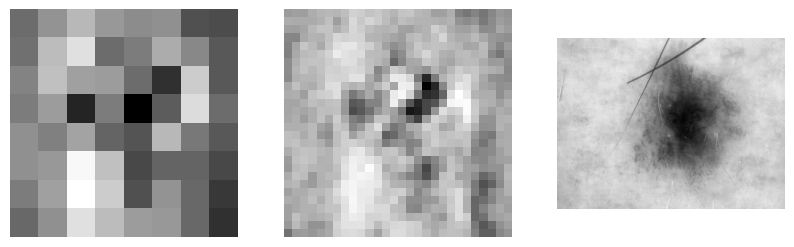

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

img1 = dataset2.iloc[0,:].to_numpy().reshape(8,8)
img2 = dataset1.iloc[0,:].to_numpy().reshape(28,28)
img3 = cv2.imread('/content/sample_data/HAM10000_images_part_1/ISIC_0024306.jpg',cv2.IMREAD_GRAYSCALE)

ax[0].imshow(img1,cmap='gray')
ax[0].axis('off')
ax[1].imshow(img2,cmap='gray')
ax[1].axis('off')
ax[2].imshow(img3,cmap='gray')
ax[2].axis('off')
io.show()

In [ ]:
metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
metadates['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [ ]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)  # Depén de vosaltres
      image = self.transform(image)

      return image, label

In [ ]:
TRAINING = 0.6
VALIDATION = 0.15
TESTING = 0.25

transform = transforms.Compose([
    transforms.ToTensor(),
])

img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
img_files = img_files_1 + img_files_2
img_files = numpy.array(img_files)

img_number = len(img_files)

labels = metadates['dx'].to_numpy()

idx_list = list(range(img_number))
random.shuffle(idx_list)

training_imgs = img_files[idx_list[:int(img_number*TRAINING)]]
training_labels = labels[idx_list[:int(img_number*TRAINING)]]

train_data = Formes(training_imgs,training_labels,transform)

validation_imgs = img_files[idx_list[int(img_number*TRAINING):int(img_number*(TRAINING+VALIDATION))]]
validation_labels = labels[idx_list[int(img_number*TRAINING):int(img_number*(TRAINING+VALIDATION))]]

validation_data = Formes(validation_imgs,validation_labels,transform)

testing_imgs = img_files[idx_list[int(img_number*(TRAINING+VALIDATION)):]]
testing_labels = labels[idx_list[int(img_number*(TRAINING+VALIDATION)):]]

testing_data = Formes(testing_imgs,testing_labels,transform)


print(len(training_imgs))
print(len(validation_imgs))
print(len(testing_imgs))

6009
1502
2504


A continuació ja podem procedir a l'entrenament